# Momentum Crossover Strategy (Single Ticker)

**Goal:** Test a classic moving-average crossover (fast vs slow) on one stock.

**Data:** Kaggle S&P 500 daily OHLCV.

**Method:** Long when SMA_fast > SMA_slow, otherwise flat. Evaluate CAGR, Sharpe, Max Drawdown, and Turnover with simple trading costs.


### 1. Imports & Config

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Config ---
CSV_PATH = "all_stocks_5yr.csv"   # path to your Kaggle file
TICKER   = "AAPL"                  # pick any ticker present in the CSV
FAST     = 50                      # fast MA window
SLOW     = 200                     # slow  MA window
COST_BPS = 10                      # per trade cost in basis points (10 bps = 0.10%)
SEED     = 7
np.random.seed(SEED)

### 2. Load & Prepare Data

In [5]:
def standardize_columns(df):
    df = df.copy()
    df.columns = [c.lower() for c in df.columns]
    if "name" in df.columns:
        df = df.rename(columns={"name": "ticker"})
    elif "symbol" in df.columns:
        df = df.rename(columns={"symbol": "ticker"})
    elif "ticker" not in df.columns:
        raise ValueError("Ticker column not found.")
    date_col = "date" if "date" in df.columns else next((c for c in df.columns if "date" in c), None)
    if date_col is None:
        raise ValueError("Date column not found.")
    df[date_col] = pd.to_datetime(df[date_col])
    return df, date_col

raw = pd.read_csv(CSV_PATH)
df, date_col = standardize_columns(raw)
dft = (df[df["ticker"]==TICKER]
       .dropna(subset=["close"])
       .sort_values(date_col)
       .reset_index(drop=True)
      )
if dft.empty:
    raise ValueError(f"No rows for ticker {TICKER} in {CSV_PATH}")

dft = dft[[date_col, "close"]].copy()
dft = dft.drop_duplicates(subset=[date_col]).set_index(date_col)
print(f"{TICKER}: {len(dft)} rows from {dft.index.min().date()} → {dft.index.max().date()}")
dft.head()


AAPL: 1259 rows from 2013-02-08 → 2018-02-07


,close
date,
2013-02-08,67.8542
2013-02-11,68.5614
2013-02-12,66.8428
2013-02-13,66.7156
2013-02-14,66.6556


### 3. Indicators, Signals, Returns

In [6]:
# Indicators
dft[f"SMA{FAST}"] = dft["close"].rolling(FAST, min_periods=FAST).mean()
dft[f"SMA{SLOW}"] = dft["close"].rolling(SLOW, min_periods=SLOW).mean()

# Signal: 1 when SMA_fast > SMA_slow else 0; shift by 1 day to avoid look-ahead
sig_raw = (dft[f"SMA{FAST}"] > dft[f"SMA{SLOW}"]).astype(int)
signal  = sig_raw.shift(1).fillna(0)

# Returns (log returns)
ret = np.log(dft["close"]).diff().fillna(0)

# Strategy returns
gross = signal * ret

# Simple trading costs: apply when signal changes (enter/exit)
turnover = signal.diff().abs().fillna(0)   # 1 when we change position, else 0
cost_per_turn = COST_BPS / 10000.0         # bps → decimal
net = gross - turnover * cost_per_turn

dft_eval = pd.DataFrame({
    "price": dft["close"],
    "signal": signal,
    "ret": ret,
    "gross": gross,
    "turnover": turnover,
    "net": net
}).dropna()
dft_eval.tail().head()


,price,signal,ret,gross,turnover,net
date,,,,,,
2018-02-01,167.78,1.0,0.002088,0.002088,0.0,0.002088
2018-02-02,160.50,1.0,-0.044360,-0.044360,0.0,-0.044360
2018-02-05,156.49,1.0,-0.025302,-0.025302,0.0,-0.025302
2018-02-06,163.03,1.0,0.040942,0.040942,0.0,0.040942
2018-02-07,159.54,1.0,-0.021640,-0.021640,0.0,-0.021640


### 4. Metrics (CAGR, Sharpe, MaxDD, Turnover)

In [7]:
def cagr(returns, freq=252):
    cum = (1 + returns).prod()
    n = returns.shape[0]
    if n == 0:
        return np.nan
    return cum**(freq/n) - 1

def sharpe(returns, freq=252):
    mu = returns.mean(); sd = returns.std(ddof=0)
    return np.sqrt(freq) * (mu / sd) if sd > 0 else np.nan

def max_drawdown(equity_curve):
    peak = equity_curve.cummax()
    dd = (equity_curve / peak) - 1.0
    return dd.min()

equity = (1 + dft_eval["net"]).cumprod()
metrics = {
    "CAGR": cagr(dft_eval["net"]),
    "Sharpe": sharpe(dft_eval["net"]),
    "Max Drawdown": max_drawdown(equity),
    "Turnover (annualized)": dft_eval["turnover"].sum() / (len(dft_eval) / 252.0),
}
pd.Series(metrics).to_frame("Value")


,Value
CAGR,0.150937
Sharpe,0.899463
Max Drawdown,-0.236274
Turnover (annualized),0.600477


### 5. Plots (Equity & Drawdown)

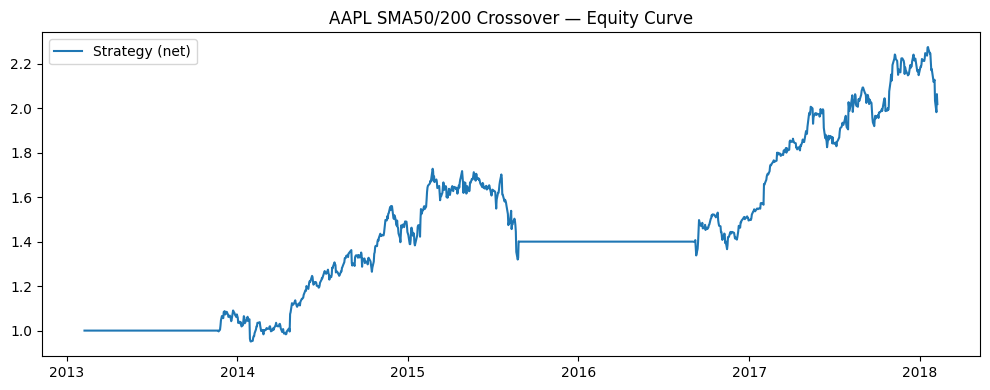

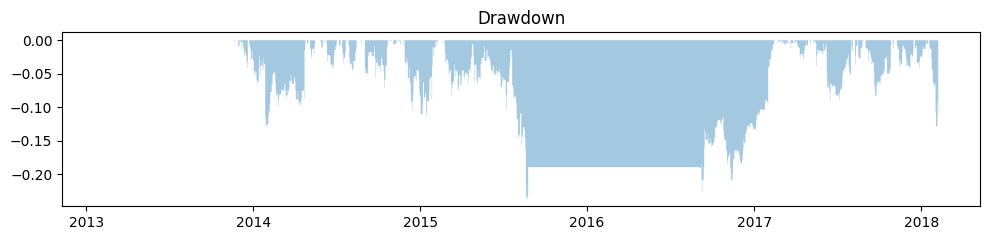

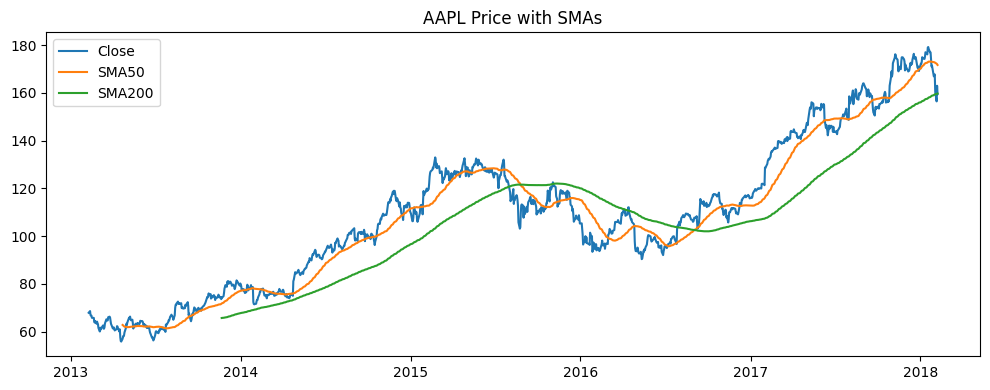

In [8]:
plt.figure(figsize=(10,4))
plt.plot(equity.index, equity.values, label="Strategy (net)")
plt.title(f"{TICKER} SMA{FAST}/{SLOW} Crossover — Equity Curve")
plt.legend(); plt.tight_layout(); plt.show()

# Drawdown
peak = equity.cummax()
drawdown = equity/peak - 1.0
plt.figure(figsize=(10,2.5))
plt.fill_between(drawdown.index, drawdown.values, 0, step="pre", alpha=0.4)
plt.title("Drawdown"); plt.tight_layout(); plt.show()

# (Optional) Price + SMAs for visual check
plt.figure(figsize=(10,4))
plt.plot(dft.index, dft["close"], label="Close")
plt.plot(dft.index, dft[f"SMA{FAST}"], label=f"SMA{FAST}")
plt.plot(dft.index, dft[f"SMA{SLOW}"], label=f"SMA{SLOW}")
plt.title(f"{TICKER} Price with SMAs"); plt.legend(); plt.tight_layout(); plt.show()


In [9]:
def cagr(ret, freq=252):
    n=len(ret);  return (1+ret).prod()**(freq/n)-1 if n>0 else np.nan
def sharpe(ret, freq=252):
    m, s = ret.mean(), ret.std(ddof=0); return np.sqrt(freq)*m/s if s>0 else np.nan
def max_dd(eq):
    peak = eq.cummax(); return (eq/peak-1).min()

equity = (1 + dft_eval["net"]).cumprod()
summary = pd.Series({
    "CAGR": cagr(dft_eval["net"]),
    "Sharpe": sharpe(dft_eval["net"]),
    "Max Drawdown": max_dd(equity),
    "Turnover/yr": dft_eval["turnover"].sum() / (len(dft_eval)/252),
})
summary.to_frame("Value")


,Value
CAGR,0.150937
Sharpe,0.899463
Max Drawdown,-0.236274
Turnover/yr,0.600477


### 6. Sensitivity Grid for FAST/SLOW

In [10]:
def backtest_sma(dfx, fast, slow, cost_bps=COST_BPS):
    px = dfx["close"]
    sma_f = px.rolling(fast, min_periods=fast).mean()
    sma_s = px.rolling(slow, min_periods=slow).mean()
    sig = (sma_f > sma_s).astype(int).shift(1).fillna(0)
    ret = np.log(px).diff().fillna(0)
    gross = sig * ret
    turnover = sig.diff().abs().fillna(0)
    net = gross - turnover * (cost_bps/10000.0)
    eq = (1+net).cumprod()
    return cagr(net), sharpe(net), max_drawdown(eq)

grid = []
for f in [20, 50]:
    for s in [100, 150, 200]:
        if f >= s: continue
        c, sh, dd = backtest_sma(dft, f, s)
        grid.append((f, s, c, sh, dd))
pd.DataFrame(grid, columns=["FAST","SLOW","CAGR","Sharpe","MaxDD"]).sort_values("Sharpe", ascending=False)


,FAST,SLOW,CAGR,Sharpe,MaxDD
4,50,150,0.181959,1.048591,-0.193719
2,20,200,0.162160,0.977770,-0.187064
5,50,200,0.150937,0.899463,-0.236274
1,20,150,0.147256,0.870895,-0.305251
0,20,100,0.122114,0.745111,-0.291062
3,50,100,0.097976,0.613544,-0.368384


## Conclusion

A simple SMA crossover (SMA50 above SMA200 = long, otherwise flat) captured medium-term trends while avoiding prolonged downtrends when price stayed below the slow average. The equity curve shows the system participating in major upswings and sitting out weak regimes; the drawdown plot confirms that risk was materially lower than staying fully invested during extended declines.

**What worked**
- Participates in sustained uptrends; avoids large losses when price is under the slow MA.
- Transparent rules and very low parameter count (robust to overfitting).
- Costs applied only on regime changes, so turnover stays manageable.

**Where it struggles**
- Choppy, sideways markets → frequent crossovers (whipsaws) and small losses.
- Performance is sensitive to the FAST/SLOW windows and fee assumptions.

**Practical notes**
- Always shift the signal by 1 day to avoid look-ahead.
- Include realistic trading costs; even 5–10 bps per switch can change results.

**Next steps**
- Run a small parameter grid (e.g., 20/100, 50/150, 50/200) and compare Sharpe/CAGR.
- Add a simple **volatility filter** (stay flat when 20-day vol is in the top X%).
- Test on multiple tickers/ETFs and report median performance across assets.
- Try risk-based sizing (e.g., scale exposure by recent volatility).
